# Group assignment on natural language processing

**Group members:** Suuraj Perpeli, Veikka Immonen

In this assignment we analyze performance of machine learning models
for natural language processing (NLP) tasks, using 🤗 Hugging Face.

## Install depencies

This notebook is designed to be used in Google Colab out-of-the-box (by definition of you don't have to do anything else outside of Colab session).
First, install required depencies by using pip...

In [1]:
!pip3 install -U -q datasets transformers accelerate bitsandbytes hnswlib peft wandb

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


...and import them

In [2]:
import torch
from torch.utils.data import DataLoader

from sentence_transformers import SentenceTransformer, CrossEncoder, util
from transformers import (AutoModelForCausalLM, AutoTokenizer, pipeline,
                          BitsAndBytesConfig, TrainingArguments, Trainer,
                          DataCollatorForLanguageModeling)
from datasets import load_dataset

from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

from huggingface_hub import login
import wandb

import hnswlib

import os
import matplotlib.pyplot as plt
import re
import numpy as np
from tqdm import tqdm

from gensim.models.word2vec import Word2Vec

## Load the dataset

We chose the Medical Meadow Medical Flashcards dataset presented by Han et al. (2023) (paper [here](https://arxiv.org/pdf/2304.08247)). This is the first subset out of four published subsets, consisting of QA flashcards of medical based questions.

The dataset can be loaded using 🤗 Datasets.

In [3]:
ds = load_dataset("medalpaca/medical_meadow_medical_flashcards")
print('Structure of data: ', ds)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

(…)l_meadow_wikidoc_medical_flashcards.json:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/33955 [00:00<?, ? examples/s]

Structure of data:  DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 33955
    })
})


The data is a dictionary ```train``` as the key and another dictionary ```Dataset```  as the value, the keys of this dictinoary are ```features``` and ```num_rows```, features being one of the ```input```, ```output```, or ```instruction```.

The ```num_rows``` suggests that there are 33955 questions and answers with instructions respectively.

Let us have a look at how each one of these are:

In [ ]:
print(f'Input :', ds['train']['input'][0])
print(f'Output :', ds['train']['output'][0])
print(f'Instruction :', ds['train']['instruction'][0])

Input : What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?
Output : Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels.
Instruction : Answer this question truthfully


The ```input```'s are questions,

The ```output```'s are answers and,

The ```instruction```'s are the instructions to answer the questions.

## Initial analysis on the data

Let's analyze the output sentences and the train a Word2Vec model by them.

First, lowercase the text, tokenizing based on spaces to prepare the text for training. Using regex, character `\W` removes the non word characters thereby removing the '+','/','-' that however could be good to keep.

In [9]:
tokenized_sentences = [re.sub(r'\W', ' ', sentence).lower().split() for sentence in ds['train']['output']]

for i in tokenized_sentences[:5]:
  print(i)

print(f'Minimum sentence len: ', min([len(i)for i in tokenized_sentences]))
print(f'Maximum sentence len: ', max([len(i)for i in tokenized_sentences]))
print(f'Average sentence len: ', np.mean([len(i)for i in tokenized_sentences]))

['very', 'low', 'mg2', 'levels', 'correspond', 'to', 'low', 'pth', 'levels', 'which', 'in', 'turn', 'results', 'in', 'low', 'ca2', 'levels']
['low', 'estradiol', 'production', 'leads', 'to', 'genitourinary', 'syndrome', 'of', 'menopause', 'atrophic', 'vaginitis']
['low', 'rem', 'sleep', 'latency', 'and', 'experiencing', 'hallucinations', 'sleep', 'paralysis', 'suggests', 'narcolepsy']
['pth', 'independent', 'hypercalcemia', 'which', 'can', 'be', 'caused', 'by', 'cancer', 'granulomatous', 'disease', 'or', 'vitamin', 'd', 'intoxication']
['the', 'level', 'of', 'anti', 'müllerian', 'hormone', 'is', 'directly', 'related', 'to', 'ovarian', 'reserve', 'a', 'lower', 'level', 'indicates', 'a', 'lower', 'ovarian', 'reserve']
Minimum sentence len:  0
Maximum sentence len:  247
Average sentence len:  54.24835812104256


We can also visualize the "distribution" of lenght of tokenized sentences.

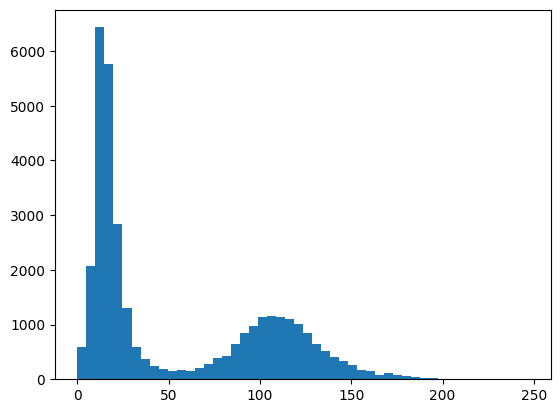

In [13]:
plt.hist([len(sen) for sen in tokenized_sentences], 50)
plt.show()

Now let's train the Word2Vec on the ```outputs```.

In [4]:
model = Word2Vec(tokenized_sentences, vector_size=100, min_count=2, window=10)
print(f'Learnt vectors: ',len(model.wv))

NameError: name 'tokenized_sentences' is not defined

One thing to try is to find most similar words using different terms.


In [16]:
# term = 'sickness'
# term = 'fever'
# term = 'cure'
term = 'drugs'

sims = model.wv.most_similar(term, topn=5)
sims

[('agents', 0.8513118028640747),
 ('drug', 0.7191038727760315),
 ('medications', 0.7175353765487671),
 ('inhibitors', 0.7173522710800171),
 ('serotonergic', 0.6758663058280945)]

## Retrieval-based chatbot

Let's build a QA chatbot based on a semantic search pipeline. Given a question
the bot tries to find a answer from a predefined corpus.

The model can be created by using SentenceTransformers.

In [5]:
semb_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
xenc_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Create the corpus and use Approximate Nearest Neighbor (ANN) to speed-up the search using corpus embeddings.

In [35]:
index_path = './hnswlib.index'
corpus = np.array(ds['train']['output'][:500])

if not os.path.exists(index_path):
  print("Creating a HNSWLIB index")
  corpus_embeddings = semb_model.encode(corpus_np, convert_to_tensor=True,
                                        show_progress_bar=True)
  index = hnswlib.Index(space='cosine', dim=corpus_embeddings.size(1))
  index.init_index(max_elements=corpus_embeddings.size(0),
                   ef_construction=256, M=64)
  index.add_items(corpus_embeddings.cpu(), list(range(len(corpus_embeddings))))
  print("Saving index to:", index_path)
  index.save_index(index_path)
else:
  empty_embeddings = semb_model.encode(corpus[:1], convert_to_tensor=True)
  index = hnswlib.Index(space='cosine', dim=empty_embeddings.size(1))
  index.load_index(index_path)


Test the ranking using question encoder and ANN.

In [80]:
query = ds['train']['input'][3]
print(f'Query : {query}')
query_embedding = semb_model.encode(query, convert_to_tensor=True)
ids, distances = index.knn_query(query_embedding.cpu(), k=32)
out = ds['train']['output'][ids[0][np.argmin(distances[0])]]
print(f'Out : {out}')
print(f"True: {ds['train']['output'][3]}")

Query : What are some possible causes of low PTH and high calcium levels?
Out : Secondary hyperparathyroidism can be caused by vitamin D deficiency in the case of low calcium, low phosphate, high PTH, and chronic kidney disease in the case of low calcium, high phosphate, high PTH.
True: PTH-independent hypercalcemia, which can be caused by cancer, granulomatous disease, or vitamin D intoxication.


Test the re-ranking using the cross-encoder.

In [81]:
model_inputs = [(query, corpus[i]) for i in ids[0]]
cross_scores = xenc_model.predict(model_inputs)
print("Cross-encoder model re-ranking results")
print(f"Query: \"{query} \"")
print("-------------------------")
for idx in np.argsort(-cross_scores)[:3]:
  print(f"Score: {cross_scores[idx]:.4f}\nDocument: \"{corpus[ids[0][idx]]}\"")

Cross-encoder model re-ranking results
Query: "What are some possible causes of low PTH and high calcium levels? "
-------------------------
Score: 6.1966
Document: "Secondary hyperparathyroidism can be caused by vitamin D deficiency in the case of low calcium, low phosphate, high PTH, and chronic kidney disease in the case of low calcium, high phosphate, high PTH."
Score: 2.6578
Document: "PTH-independent hypercalcemia, which can be caused by cancer, granulomatous disease, or vitamin D intoxication."
Score: 0.2741
Document: "Low Ca2+ and low PTH is seen in primary hypoparathyroidism."


Generate the responce function.

Note that the function `chatbot` takes a list (or `np.array`) of questions. In case of one question, put it in a list.

In [72]:
def chatbot(questions, index=index, corpus=corpus, semb_model=semb_model, xenc_model=xenc_model, top_k=32):

    questions = np.array(questions)
    question_embedding = semb_model.encode(questions, convert_to_tensor=True).cpu()
    corpus_ids, _ = index.knn_query(question_embedding, k=top_k)

    answers = corpus[corpus_ids]
    questions = np.stack([questions for _ in range(top_k)], 1)
    pairs = np.stack([questions, answers], 2)

    scores = np.stack([xenc_model.predict(pair) for pair in pairs])
    idx = np.argmax(scores, 1, keepdims=True)
    answers = np.take_along_axis(answers, idx, 1).flatten()

    return answers

Test the chatbot.

In [87]:
questions = np.array(ds['train']['input'])[:50]
true = corpus[:50]

res = chatbot(questions, top_k=32) == true
res.mean()

0.9

## Generative Chatbot

Download the model and tokenizer, model as quantized

In [ ]:
name = "gpt2"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(name)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
corpus = ds['train']['output'][:100]    # create a corpus of 100 docs
model = SentenceTransformer('all-mpnet-base-v2')
corpus_embeddings = model.encode(corpus, convert_to_tensor=True)

In [ ]:
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16,
                                         bnb_4bit_quant_type="nf4",
                                         bnb_4bit_use_double_quant=True)

model = AutoModelForCausalLM.from_pretrained(name, device_map="auto",
                                             bos_token_id=tokenizer.bos_token_id,
                                             eos_token_id=tokenizer.eos_token_id,
                                             quantization_config=quantization_config)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Linear4bit(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear4bit(in_features=768, out_features=768, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Linear4bit(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear4bit(in_features=3072, out_features=768, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_a

Format data for training

In [ ]:
alpaca_prompt = """Instruction: {}

Question: {}

Answer: {}"""

def format(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        text = alpaca_prompt.format(instruction, input, output)
        texts.append(text)
    return {"text": texts}


ds = ds.map(format, batched=True)

print(ds)
print(ds['train']['text'][0])

Map:   0%|          | 0/33955 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction', 'text'],
        num_rows: 33955
    })
})
Instruction: Answer this question truthfully

Question: What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?

Answer: Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels.


In [10]:
plt.hist([len(sample['text'].split()) for sample in ds['train']], 50)
plt.show()

KeyError: 'text'

In [ ]:
max_length = 400

def tokenize(examples):
    inputs = tokenizer(examples["text"], truncation=True,
                       max_length=max_length, return_overflowing_tokens=True)
    return inputs

ds_encoded = ds.map(tokenize, batched=True, remove_columns=ds["train"].column_names)
ds_encoded

Map:   0%|          | 0/33955 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'overflow_to_sample_mapping'],
        num_rows: 33955
    })
})

Create LoRA configuration for QLoRA

In [ ]:
adapter_configs = {
    'target_modules': 'all-linear',
    'lora_alpha': 2,
    'lora_dropout': 0.05,
    'r': 4,
    'bias': 'none',
    'task_type': 'CAUSAL_LM'
}

lora_configs = LoraConfig(**adapter_configs)

prepared_model_4bit = prepare_model_for_kbit_training(model)
qlora_model = get_peft_model(prepared_model_4bit, lora_configs)

qlora_model.print_trainable_parameters()

trainable params: 589,824 || all params: 125,029,632 || trainable%: 0.4717


In [ ]:
data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [3]:
wandb.init(mode="disabled")

In [ ]:
sample = [ds_encoded['train'][i]['input_ids'] for i in range(1)]
collated = data_collator(sample)

print(collated.keys())

dict_keys(['input_ids', 'labels'])


In [ ]:
train_args = TrainingArguments(
    num_train_epochs=1,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=8,
    learning_rate=1e-4,
    bf16=True,
    logging_steps=8,
    output_dir="outputs",
)
trainer = Trainer(
    model=qlora_model,
    processing_class=tokenizer,
    train_dataset=ds_encoded['train'],
    args=train_args,
    data_collator=data_collator,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
8,23.411100
16,23.570500
24,23.278800
32,22.556300
40,22.106700
48,21.893400
56,21.469300
64,20.767900
72,20.304300
80,20.106800


## Training wrapper with Lightning (not used)

Create collat function for tokenized inputs/outputs

In [ ]:
def collate(mini_batch):
    input_encodings = tokenizer([sample['text'] for sample in mini_batch], return_tensors='pt', padding=True)
    labels = input_encodings.input_ids.clone()
    labels[~input_encodings.attention_mask.bool()] = -100

    return input_encodings, labels

data_loader = DataLoader(
    ds['train'], collate_fn=collate, shuffle=True, batch_size=16
)

Wrap model into a PyTorch Lightning module

In [ ]:
!pip install -q lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 42.4 MB/s eta 0:00:00


In [ ]:
import lightning as L
from torch.optim import AdamW
import torch.nn.functional as F

class LightningWrapper(L.LightningModule):
    def __init__(self, model, tokeniser, lr=1.e-5):
        super().__init__()
        self._model = model
        self._tokeniser = tokeniser
        self._lr = lr

    def configure_optimizers(self):
        # Build optimiser
        optimiser = AdamW(self.parameters(), lr=self._lr)

        return optimiser

    def forward(self, *args, **kwargs):
        return self._model.forward(*args, **kwargs)

    def training_step(self, mini_batch, mini_batch_idx):
        # Unpack the encoding and the target labels
        input_encodings, labels = mini_batch
        # Run generic forward step
        output = self.forward(**input_encodings)
        # Compute logits
        logits: torch.tensor = output.logits
        # Shift logits to exclude the last element
        logits = logits[..., :-1, :].contiguous()
        # shift labels to exclude the first element
        labels = labels[..., 1:].contiguous()
        # Compute LM loss token-wise
        loss: torch.tensor = F.cross_entropy(logits.view(-1, logits.size(-1)), labels.view(-1))

        return loss

lightning_model = LightningWrapper(qlora_model, tokenizer)

Training

In [ ]:
trainer = L.Trainer(
    accumulate_grad_batches=32,
    precision='bf16-mixed',  # Mixed precision (bf16-mixed or 16-mixed)
    gradient_clip_val=1.0,  # Gradient clipping
    max_epochs=1
)

INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(lightning_model, train_dataloaders=data_loader)